In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import os
import sys
from torch.utils.data import DataLoader
from patsy import dmatrix
import torch
sys.path.append(os.path.abspath('../src'))

from data_tools.data_utils import create_data_split

In [2]:
project_dir = project_dir = Path.cwd().parent
trunc_D = 40

create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)

complete_df = pd.read_csv(project_dir / "data" / "model" / "complete_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:21: DtypeWarning: Columns (22,44,45,46,54,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(os.path.join(base_folder_path, file)) for file in files]
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:21: DtypeWarning: Columns (22,44,45,46,54,56,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(os.path.join(base_folder_path, file)) for file in files]
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:21: DtypeWarning: Columns (22,44,45,46,54,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(os.path.join(base_folder_path, file)) for file in files]
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_u

: 

In [ ]:
class ReportingDataset():
    def __init__(self, df, D):
        self.df = df.copy()
        self.D = D
        self.max_val = self.df.values.max()
    
    def get_obs(self, idx, n_points, norm=False, mask=False):
        # Ignore first D days to ensure full matrix
        t = idx + self.D


        # Create reporting triangle for day t
        matrix = self.df.iloc[t - n_points + 1: t + 1, :self.D].values
        
        # Mask last D days
        if mask:
            matrix[-self.D:] = self.mask_matrix(matrix[-self.D:])

        if norm:
            return matrix / self.max_val
        else:
            return matrix
    
    def get_y(self, idx):
        t = idx + self.D
        return self.df.iloc[t].sum()

    def get_date(self, idx):
        t = idx + self.D
        return self.df.index[t]


    def get_past_triangles(self, idx, n_points=1, norm=True):
        assert n_points >= 1, "n must be non-negative"
        assert idx + 1 >= n_points, "idx must be at least as big as number of points"
        triangles = np.zeros(shape=(n_points, self.D, self.D))
        t_vals = np.arange(idx-n_points+1, idx+1)
        for i, t in enumerate(t_vals):
            triangles[i, :, :] = self.get_obs(t, n_points=self.D, norm=norm)

        return triangles

    def get_masked_matrix(self):
        mask_matrix = np.ones(shape=(self.D, self.D), dtype=bool)
        for i in range(self.D):
            for j in range(self.D):
                if i + j > self.D - 1:
                    mask_matrix[i, j] = False
        return mask_matrix


data_obj = ReportingDataset(complete_df, D=trunc_D)

In [ ]:
print(complete_df.index[2132])
print(complete_df.index[2844 - 41])
len(complete_df)

2018-12-12
2020-10-13


2844

* point plots of actual on X with prediction on Y, differnt models in different facets
* Evaluate forecasting methods across variety of metrics:
    * CRPS
    * IS
    * WIS
    * PICA

In [ ]:
def silu(x):
    return x * pm.math.sigmoid(x)


def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        cores=1,
        init="adapt_diag",
        chains=1,
        draws=500,
        tune=500,
        target_accept=0.95,
        max_treedepth=10,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

def run_BNN_model(data_obj, obs, triangles_flat, X_trend, X_week, t_model, t_week, mask_matrix, progressbar=False):
    with pm.Model() as model:
        T, D = obs.shape

         # Trend spline coefficients
        sigma_trend = pm.HalfNormal("sigma_trend", 3)
        beta_trend = pm.Normal("beta_trend", mu=0, sigma=sigma_trend, shape=X_trend.shape[1])
        
        # Cyclic spline coefficients (seasonality)
        sigma_week = pm.HalfNormal("sigma_week", 3)
        beta_week = pm.Normal("beta_week", mu=0, sigma=sigma_week, shape=X_week.shape[1])
        
        
        #Linear Trend
        # sigma_linear = pm.HalfNormal("sigma_linear", 2)
        # beta_linear = pm.Normal("beta_linear", mu=0, sigma=sigma_linear, shape=(1))
        # intercept = pm.Normal("intercept", mu=0, sigma=10)

        # AR residuals
        # order = 1
        # rho_raw = pm.Beta("rho_raw", alpha=2, beta=2)
        # rho = pm.Deterministic("rho", 2 * rho_raw - 1)
        # init = pm.Normal.dist(mu=0, sigma=1, shape=1)
        # ar = pm.AR("ar", rho=rho, sigma=0.5, init_dist=init, constant=False, shape=T)

        

        log_lam = pm.Deterministic(
            "log_lam", pm.math.dot(X_trend, beta_trend) + pm.math.dot(X_week, beta_week)
        )
        # log_lam = pm.Deterministic(
        #     "log_lam", beta_linear * t_model + intercept
        # )

        lam = pm.Deterministic("lam", pm.math.exp(log_lam))

        # NN for proportions
        n_hidden = 8
        net_sd = 0.2
        W1 = pm.Normal("W1", 0, net_sd, shape=(data_obj.D * data_obj.D, n_hidden))
        b1_net = pm.Normal("b1_net", 0, net_sd, shape=(n_hidden,))
        h1 = silu(pm.math.dot(triangles_flat, W1) + b1_net)

        W2 = pm.Normal("W2", 0, net_sd, shape=(n_hidden, data_obj.D))
        b2_net = pm.Normal("b2_net", 0, net_sd, shape=(data_obj.D,))
        p_raw = pm.math.dot(h1, W2) + b2_net

        # t_week_onehot = np.eye(7)[t_week]
        # W_dow = pm.Normal("W_dow", 0, net_sd, shape=(7, data_obj.D))
        # p_dow = pm.math.dot(t_week_onehot, W_dow)
        

        p_raw = pm.math.clip(p_raw, -15, 15)

        temperature = 1
        p = pm.Deterministic("p", pm.math.softmax(p_raw/temperature, axis=1))

        log_mu = pm.math.log(lam[:, None]) + pm.math.log(p + 1e-6)
        mu = pm.Deterministic("mu", pm.math.exp(log_mu))

        
        alpha = pm.Exponential("alpha", 3)
        z = pm.NegativeBinomial("z", mu[mask_matrix], alpha, observed=obs[mask_matrix])
        
        idata = pm.sample(progressbar=progressbar, **sampler_kwargs())

    return idata


In [ ]:
def create_fourier_features(t, n, p=10.0):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)




# Constants
n_points = 50
t_model = np.arange(0, n_points)
t_week = t_model % 7

t_model = t_model / n_points

spline_trend = dmatrix(
    "bs(t, df=10, degree=3, include_intercept=False)", {"t": t_model}, return_type='dataframe'
)
X_trend = np.asarray(spline_trend)

spline_week = dmatrix(
    "cc(t_week, df=6)", {"t_week": t_week}, return_type='dataframe'
)
X_week = np.asarray(spline_week)




X_fourier = create_fourier_features(t_model, n=14, p=3.5)


# Create mask
mask_matrix = np.ones((n_points, data_obj.D), dtype=bool)
if n_points > data_obj.D:
    mask_matrix[-data_obj.D:,:] = data_obj.get_masked_matrix()
else:
    mask_matrix = data_obj.get_masked_matrix()[-n_points:,:]



In [ ]:
obs = data_obj.get_obs(t, n_points)
triangles = data_obj.get_past_triangles(t, n_points, norm=False)
triangles_flat = triangles.reshape((n_points, data_obj.D * data_obj.D)) / triangles.max()


idata = run_BNN_model(data_obj, obs, triangles_flat, X_trend, X_week, t_model, t_week, mask_matrix, progressbar=False)
lam_post_samples = az.extract(idata, group='posterior', num_samples=1000)['lam']

In [7]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm


def run_single_t(t):
    obs = data_obj.get_obs(t, n_points)
    triangles = data_obj.get_past_triangles(t, n_points, norm=False)
    triangles_flat = triangles.reshape((n_points, data_obj.D * data_obj.D)) / triangles.max()
    

    idata = run_BNN_model(data_obj, obs, triangles_flat, X_trend, X_week, t_model, t_week, mask_matrix, progressbar=False)
    lam_post_samples = az.extract(idata, group='posterior', num_samples=1000)['lam']
    return lam_post_samples


# 2019 - 2112:2477

t1 = 2112
t2 = 2477
BNN_preds = Parallel(n_jobs=4)(
    delayed(run_single_t)(t) for t in tqdm(range(t1, t2))
)



100%|██████████| 365/365 [15:54:57<00:00, 156.98s/it]  


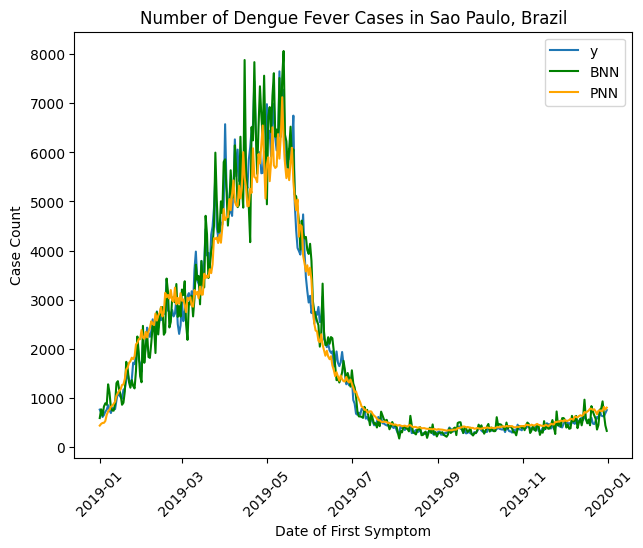

In [41]:


# Select sameday nowcast
BNN_forecasts = np.array(BNN_preds)[:,-1,:] 
BNN_preds_med = np.quantile(BNN_forecasts, 0.5, axis=-1) 

# One day diverged
BNN_preds_med[259] = BNN_preds_med[258]



# BNN_preds_med = BNN_preds_med * data_obj.max_val

PNN_df = pd.read_csv(project_dir / "data" / "model" / "PNN_results.csv")
PNN_df = PNN_df.iloc[trunc_D + t1+1:trunc_D + t2+1]
PNN_preds = PNN_df['preds']

y_plot = [data_obj.get_y(idx) for idx in np.arange(t1, t2)]
dates = [pd.to_datetime(data_obj.get_date(idx)) for idx in np.arange(t1, t2)]


plt.plot(dates, y_plot, label='y')

plt.plot(dates, BNN_preds_med, label='BNN', color='green')
# plt.fill_between(dates, BNN_lower, BNN_upper, color='green', alpha=0.2, label='BNN 95% CI')



plt.plot(dates, PNN_preds, label='PNN', color='orange')
# plt.fill_between(dates, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()

In [212]:
BNN_preds[0].shape

(100, 1000)

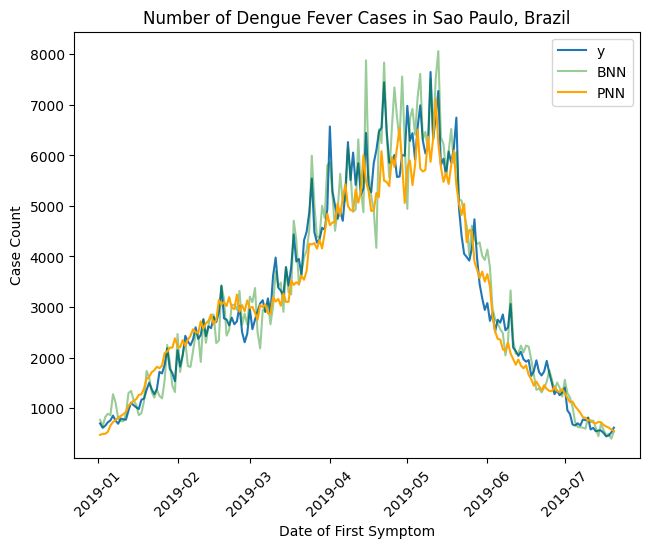

In [215]:
t1 = 2112
t2 = 2477

# Select sameday nowcast
BNN_forecasts = np.array(BNN_preds)[:,-1,:] 
BNN_preds_med = np.quantile(BNN_forecasts, 0.5, axis=-1) 

# One day diverged
BNN_preds_med[259] = BNN_preds_med[258]


start_idx = 1
length = 200

BNN_preds_med = BNN_preds_med[start_idx:start_idx + length]

PNN_df = pd.read_csv(project_dir / "data" / "model" / "PNN_results.csv")
PNN_df = PNN_df.iloc[trunc_D + t1+1:trunc_D + t2+1]
PNN_preds = PNN_df['preds'][start_idx:start_idx + length]

y_plot = [data_obj.get_y(idx) for idx in np.arange(t1, t2)][start_idx:start_idx + length]
dates = [pd.to_datetime(data_obj.get_date(idx)) for idx in np.arange(t1, t2)][start_idx:start_idx + length]


plt.plot(dates, y_plot, label='y')

plt.plot(dates, BNN_preds_med, label='BNN', color='green', alpha=0.4)
# plt.fill_between(dates, BNN_lower, BNN_upper, color='green', alpha=0.2, label='BNN 95% CI')



plt.plot(dates, PNN_preds, label='PNN', color='orange')
# plt.fill_between(dates, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()

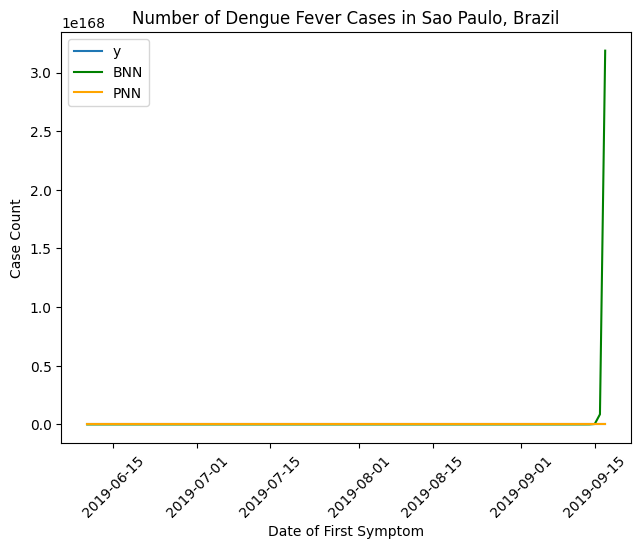

In [26]:
# Single period fit
rel_idx = 259
BNN_preds_med = np.quantile(BNN_preds[rel_idx], 0.5, axis=-1)

PNN_df = pd.read_csv(project_dir / "data" / "model" / "PNN_results.csv")
PNN_df = PNN_df.iloc[trunc_D + t1 - n_points + rel_idx:trunc_D + t1 + rel_idx]
PNN_preds = PNN_df['preds']

y_plot = [data_obj.get_y(idx) for idx in np.arange(t1-n_points + 1 + rel_idx, t1+ 1 + rel_idx)]
dates = [pd.to_datetime(data_obj.get_date(idx)) for idx in np.arange(t1-n_points + 1 + rel_idx, t1+1 + rel_idx)]


plt.plot(dates, y_plot, label='y')

plt.plot(dates, BNN_preds_med, label='BNN', color='green')
# plt.fill_between(dates, BNN_lower, BNN_upper, color='green', alpha=0.2, label='BNN 95% CI')



plt.plot(dates, PNN_preds, label='PNN', color='orange')
# plt.fill_between(dates, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()

In [293]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm


def run_single_t(t):
    obs = data_obj.get_obs(t, n_points)
    triangles = data_obj.get_past_triangles(t, n_points, norm=False)
    triangles_flat = triangles.reshape((n_points, data_obj.D * data_obj.D)) / triangles.max()
    

    idata = run_BNN_model(data_obj, obs, triangles_flat, X_trend, X_week, t_model, t_week, mask_matrix, progressbar=False)
    lam_post_samples = az.extract(idata, group='posterior', num_samples=1000)['lam']
    return lam_post_samples


# 2019 - 2112:2477

t1 = 2112
t2=2120
BNN_preds_2 = Parallel(n_jobs=4)(
    delayed(run_single_t)(t) for t in tqdm(range(t1, t2))
)



100%|██████████| 8/8 [02:18<00:00, 17.29s/it]


In [255]:
print(np.array(BNN_preds_2)[:,-1,:].shape)

(8, 500)


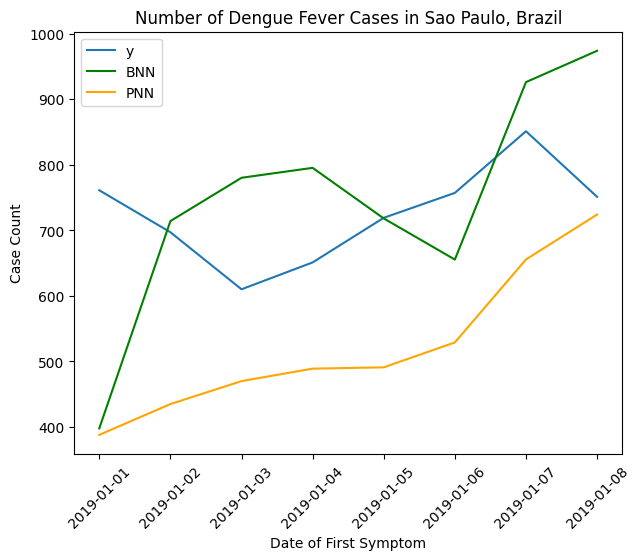

In [294]:
t1 = 2112
t2=2120

# Select sameday nowcast
BNN_forecasts = np.array(BNN_preds_2)[:,-1,:] 
BNN_preds_med = np.quantile(BNN_forecasts, 0.5, axis=-1) 




# BNN_preds_med = BNN_preds_med * data_obj.max_val

PNN_df = pd.read_csv(project_dir / "data" / "model" / "PNN_results.csv")
PNN_df = PNN_df.iloc[trunc_D + t1:trunc_D + t2]
PNN_preds = PNN_df['preds']

y_plot = [data_obj.get_y(idx) for idx in np.arange(t1, t2)]
dates = [pd.to_datetime(data_obj.get_date(idx)) for idx in np.arange(t1, t2)]


plt.plot(dates, y_plot, label='y')

plt.plot(dates, BNN_preds_med, label='BNN', color='green')
# plt.fill_between(dates, BNN_lower, BNN_upper, color='green', alpha=0.2, label='BNN 95% CI')



plt.plot(dates, PNN_preds, label='PNN', color='orange')
# plt.fill_between(dates, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()

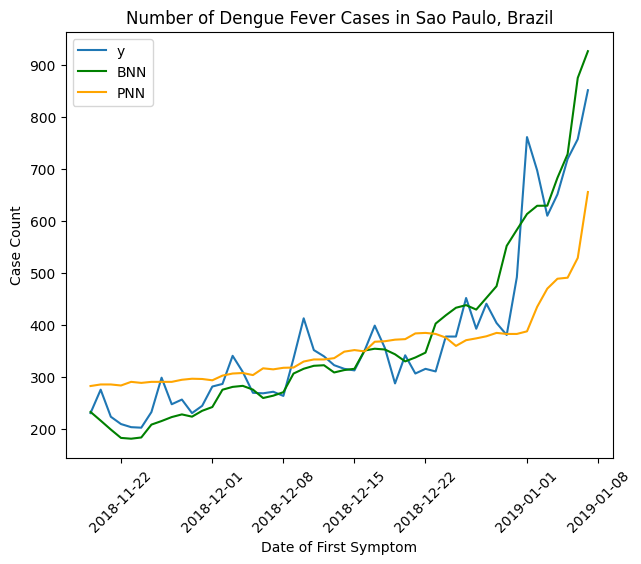

In [296]:

rel_idx = 6
# Select sameday nowcast
BNN_forecasts = np.array(BNN_preds_2)[rel_idx] 
BNN_preds_med = np.quantile(BNN_forecasts, 0.5, axis=-1) 




# BNN_preds_med = BNN_preds_med * data_obj.max_val

PNN_df = pd.read_csv(project_dir / "data" / "model" / "PNN_results.csv")
PNN_df = PNN_df.iloc[trunc_D + t1 - n_points + rel_idx + 1:trunc_D + t1 + rel_idx + 1]
PNN_preds = PNN_df['preds']

y_plot = [data_obj.get_y(idx) for idx in np.arange(t1-n_points + rel_idx + 1, t1 + rel_idx + 1)]
dates = [pd.to_datetime(data_obj.get_date(idx)) for idx in np.arange(t1-n_points + rel_idx + 1, t1 + rel_idx + 1)]


plt.plot(dates, y_plot, label='y')

plt.plot(dates, BNN_preds_med, label='BNN', color='green')
# plt.fill_between(dates, BNN_lower, BNN_upper, color='green', alpha=0.2, label='BNN 95% CI')



plt.plot(dates, PNN_preds, label='PNN', color='orange')
# plt.fill_between(dates, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()